# Probabilistic Programming in Python using PyMC

Authors: John Salvatier, Thomas V. Wiecki, Christopher Fonnesbeck

## Introduction
Probabilistic Programming (PP) allows flexible specification of statistical Bayesian models in code. PyMC3 is a new, open-source PP framework that features next generation Markov chain Monte Carlo (MCMC) sampling algorithms such as Hamiltonian Monte Carlo (HMC; Duane 87). This class of sampler allows PP to work on models that previously where extremely challenging to estimate because of their high dimensionality or complex posterior distribution. As such, PyMC3, together with the Stan () package, is currently the only PP package to offer HMC.

In contrast to most other PP frameworks, PyMC3 allows model specification in Python using an intuitive, readable syntax. Implementing a probabilistic programming system in Python confers a number of advantages including multi-platform compatibility, ease of use (particularly for non-computer scientists), and extensibility. While most of PyMC3 is written in pure Python, it relies on Theano (Bergstra et al., 2010) to transparently transcode models to C and compile it to machine code, thereby boosting performance. Additionally, Theano natively supports automatic differentation for computing gradients, which is required to implement modern gradient-based sampling algorithms, such as Hamilitonian Monte Carlo (HMC) and the No U-Turn Sampler (NUTS).

PyMC3 is a complete rewrite of PyMC version 2 (Patil et al. 2010), which is engineered to take advantage of the expression evaluation engine of Theano, while retaining the concise, approachable syntax of previous versions. Importantly, implementing PyMC in Theano obivated the need for the large library Fortran extensions required by PyMC2 which made installing the software inconvenient for many users. Moreover, the incorporation of the Patsy package has allowed for the specification of general linear models with hierarchical structure into one-line expressions. 

A list of key PyMC3 features includes:

  * Intuitive model specification syntax, for example, x ~ N(0,1) translates to x = Normal(0,1)
  * Powerful sampling algorithms such as Hamiltonian Monte Carlo
  * Easy optimization for finding the maximum a posteriori point
  * Theano features
    *   Numpy broadcasting and advanced indexing
    *   Linear algebra operators
    *   Computation optimization and dynamic C compilation
  * Simple extensibility
  * Database backends for storing simulation output
  * Parallel sampling


## Installation

Running PyMC requires a working Python interpreter, either version 2.7 (or more recent) or 3.4 (or more recent); we recommend that new users install version 3.4. A complete Python installation for Mac OSX, Linux and Windows can most easily be obtained by downloading the free [`Anaconda Python Distribution`](https://store.continuum.io/cshop/anaconda/) by ContinuumIO, and installing it. 

Prior to installing PyMC3, there are several third-party Python packages upon which it depends. The four required dependencies are: `Theano`, `NumPy`, `SciPy`, and `Matplotlib`. To take full advantage of PyMC, the optional dependencies `Pandas` and `Patsy` should also be installed. The source code for PyMC is hosted on GitHub at https://github.com/pymc-devs/pymc and is distributed under the liberal [Apache License 2.0](https://github.com/pymc-devs/pymc/blob/master/LICENSE). On the GitHub site, users may also report bugs and other issues, as well as contribute code to the project, which we actively encourage.

After successfull installation, `PyMC3` can be installed using `pip`:

```
pip install git+https://github.com/pymc-devs/pymc3
```


## Model specification

Consider the following linear Bayesian model:

$$\begin{aligned} 
Y  &\sim \mathcal{N}(\alpha + X \beta, \epsilon) \\
\alpha &\sim \mathcal{N}(0, 1) \\
\beta &\sim \mathcal{N}(0, 1) \\
\epsilon &\sim \mathcal{N}(0, \sigma) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}$$

where $X$ is a vector of predictors, and $Y$ is a vector outcome variable; $\alpha$ the intercept, and $\beta$ the slope regression coefficients which follow a standard normal distribution. $\sigma$ represents the error term and is modeled as the absolute of a Normal distribution (so-called *HalfNormal*).

We can simulate some data from this model, and use PyMC to estimate the corresponding parameters.

In [2]:
import numpy as np

# Intialize random number generator
np.random.seed(123)

# Size of dataset
size = 100

# Predictor variable
X = np.linspace(0, 1, size)

# True parameter values
alpha, beta = 1, 1

# Simulate outcome variable
Y = alpha + X*beta + np.random.randn(size)

# Define helper function
def print_public(module):
    import pprint
    pprint.pprint([name for name in dir(module) if name[0].istitle()])

Here is what the simulated data look like.

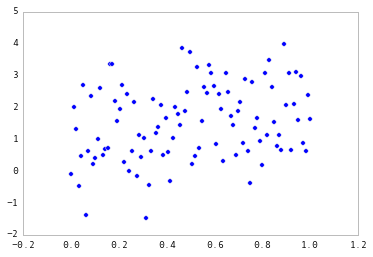

In [3]:
%matplotlib inline
import pylab as pl

pl.scatter(X, Y);

Implementing the model in PyMC3 is straightforward because the syntax is as close to writing pseudo-code as possible. For the most part, each line of Python code corresponds to each line in the model notation above. First, let's import the components we will need from PyMC.

In [4]:
from pymc3 import Model, Normal, HalfNormal

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Now we write the model as follows:

In [5]:
with Model() as model_linear:
    
    # Unknown model parameters
    alpha = Normal('alpha', mu=0, sd=1)
    beta = Normal('beta', mu=0, sd=1)
    sigma = HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta * X
    
    # Data likelihood
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Though we only required two distributions for this model, `PyMC3` includes the most commonly-used discrete and continuous probability distributions in the `distibutions` sub-module.

In [6]:
from pymc3 import distributions

print_public(distributions)

['Bernoulli',
 'Beta',
 'BetaBin',
 'Binomial',
 'Bound',
 'Categorical',
 'Cauchy',
 'ChiSquared',
 'ConstantDist',
 'Continuous',
 'DensityDist',
 'Dirichlet',
 'Discrete',
 'DiscreteUniform',
 'Distribution',
 'Exponential',
 'Flat',
 'Gamma',
 'Geometric',
 'HalfCauchy',
 'HalfNormal',
 'InverseGamma',
 'LKJCorr',
 'Laplace',
 'Lognormal',
 'Multinomial',
 'MvNormal',
 'NegativeBinomial',
 'Normal',
 'Pareto',
 'Poisson',
 'T',
 'Tpos',
 'Uniform',
 'Wald',
 'Weibull',
 'Wishart',
 'ZeroInflatedPoisson']


Each of `alpha`, `beta` and `sigma` are **stochastic** nodes in the model graph, meaning that it takes on a value that is only partly determined by the values of its parents. Therfore, stochastic nodes are assigned functional forms that describe the prior uncertainty in their values, conditional on its parents. The first argument for the built-in distributions is the *name* of the random variable (RV), so that values can be indexed from the model conveniently by their name. Next are the parameters of the distribution, which in most cases are one or two values which determine the location, shape or scale of the random variable, depending on the parameterization of the distribution.

Detailed notes about each PyMC object are available via the `help` function.

In [7]:
help(Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal log-likelihood.
 |  
 |  .. math::
ight\}
 |  
 |  Parameters
 |  ----------
 |  mu : float
 |      Mean of the distribution.
 |  tau : float
 |      Precision of the distribution, which corresponds to
 |      :math:`1/\sigma^2` (tau > 0).
 |  sd : float
 |      Standard deviation of the distribution. Alternative parameterization.
 |  
 |  .. note::
 |  - :math:`E(X) = \mu`
 |  - :math:`Var(X) = 1/        au`
 |  
 |  Method resolution order:
 |      Normal
 |      pymc3.distributions.distribution.Continuous
 |      pymc3.distributions.distribution.Distribution
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, mu=0.0, tau=None, sd=None, *args, **kwargs)
 |  
 |  logp(self, value)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from pymc3.distributions.distribution.Distribut

The `mu` node is a **deterministic** object, meaning that its value is completely determined by its parents' values. Hence, there is no stochasticity beyond the uncertainty in the parents' values. Here, `mu` is just the sum of the intercept `alpha` and the product of the slope `beta` and the predictor variable. Notice how PyMC objects and data can be arbitrarily added, subtracted, divided and multiplied together, allowing for great model expressivity.

The final piece of the model, `Y_obs`, is an **observed stochastic**, and represents the data likelihood of the model. It provides the evidence from the data to the model, and is identical to a standard stochastic, except that it is given an `observed` argument. his is how the data are passed to the model, in the form of a `numpy.ndarray` or `pandas.DataFrame` object, and indicates to PyMC that the value of the node should not change, since the data are fixed.

Notice that the model resides in an indented block, following the line:

```python
with Model() as model:
```

The `with` statement denotes a **context manager**, whereby the `Model` (that we here bind to the label `model`) is associated with each of the PyMC objects that are introduced withing the subsequent block. PyMC uses this context to register each variable with `model`. Absent this context manager idiom, we would be forced to manually associate each of the variables with `model`.

`Theano` has advanced matrix notation capabilities that enable `PyMC3` to handle multivariate statistics, including advanced indexing and slicing. Using matrix algebra, the above model can be rewritten in a more succinct form, using a vector of linear model covariates:

$$\theta = [\alpha, \beta]$$

For this, we require a column of ones to properly specify the intercept term.

In [8]:
import pandas as pd

X_1 = pd.DataFrame([np.ones_like(X), X]).T
X_1.head()

,0,1
0,1,0.000000
1,1,0.010101
2,1,0.020202
3,1,0.030303
4,1,0.040404


The corresponding model now employs a single vector-valued stochastic `theta` that represents the linear coefficients (notice that we have specified `shape=2`). Further, we can use Theano's dot product function `dot` to perform matrix array multiplication.

In [9]:
import theano.tensor as T

with Model() as model_matrix:
    
    theta = Normal('theta', 0, 1, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    mu = T.dot(X_1, theta)
    Y_obs = Normal('Y_obs', mu, sd=sigma, observed=Y)

At this point it is worth noting that RVs in `PyMC3` behave like Theano expressions, which makes them very versatile. For example, using Theano's `sigmoid` function from the neural net (`nnet`) submodule, we can easily turn this linear regression into a logistic regression.

Perhaps we are now trying to predict the values of `Y` that are greater than zero:

In [10]:
Z = Y > 0

We now use a Bernoulli likelihood, with probability $p = \text{sig}(X \theta)$ in place of the normal likelihood.

In [11]:
from pymc3 import Bernoulli

with Model() as model_logistic:
    
    theta = Normal('theta', 0, 1, shape=(2, 1))
    p = T.nnet.sigmoid(T.dot(X_1, theta))
    Z_obs = Bernoulli('Y_obs', p=p, observed=Z)

Later, we describe how more complex GLMs can easily be created in one line using the `glm` submodule of `PyMC3` but let us first turn our attention to inference.

> ### Note on Random Variables and Probability Distributions
> As a final note on model specification, `PyMC3` differentiates between RVs and probability distributions. RVs, as we specified in the models above, are specified by a probability distribution and a name, and are associated with a model. In contrast, probability distributions can exist outside of a `Model` context and don't require names. 

> To create a probability distribution instead of a RV, we use the `.dist` classmethod for the distribution of interest. For example:

In [12]:
normal_dist = Normal.dist(mu=0, sd=1)

> To use the distribution, we pass values to its `logp` method, then force Theano to evaluate the resulting expression graph with the `eval` method.

In [13]:
normal_dist.logp(2.1).eval()

array(-3.1239385332046727)

## Posterior Inference

So far, we have simply specified models, resulting in a Theano expression graph  that allows computation of the summed log probability of the model. On demand, we can ask Theano to perform algebraic simplifications and compile the symbolic computation graph to C code and compile this, in turn, to machine code. All of this functionality happens transparently and does not burden the `PyMC3` code base. 

Our objective in constructing probabilistic models is to obtain posterior inference for the unobserved stochastics in the model.

$$Pr(\theta | y) \propto Pr(y | \theta) Pr(\theta)$$

where $Pr(\theta)$ is the joint prior of the stochastics and $Pr(y | \theta)$ is the observed stochastic, or data likelihood; deterministic nodes are not relevant to the joint posterior probability.

For most models of interest, the normalizing constant for Bayes' formula is not available in closed form, and must be obtained by optimization or simulation-based methods. One such approach is the **maximum a posteriori (MAP)** estimate, which uses optimization to obtain the modes of the unnormalized posterior distribution (which are equivalent to the normalized modes). The `find_MAP` function provides this method.

In [14]:
from pymc3 import find_MAP

with model_matrix:
    start = find_MAP()
    
print(start)

{'theta': array([ 1.03304292,  0.96214966]), 'sigma': array(1.1214199548852277)}


Notice that `find_MAP` is executed in the model's context, and therefore does not require the model as an argument.

By default, `PyMC3` uses BFGS optimization but also allows selection of other optimization algorithms from the `scipy` module:

In [15]:
from scipy import optimize

with model_matrix:
    start = find_MAP(fmin=optimize.fmin_powell)
    
print(start)

{'theta': array([ 1.03338202,  0.9618749 ]), 'sigma': array(1.1207891768837501)}


Though MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is not usually sufficient for infernce because there is no associated estimate of uncertainty of the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from independent samples from the true posterior. 

To conduct MCMC sampling to generate posterior samples in PyMC3, we have instantiate a **step method** object that corresponds to a particular MCMC algorithm, such as Metropolis or Slice sampling. PyMC's `step_methods` submodule contains the following samplers, as well as proposal distributions that are used by several of the samplers:

In [16]:
from pymc3 import step_methods

print_public(step_methods)

['BinaryMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'ElemwiseCategoricalStep',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'Slice']


Of special note are the new class of Hamiltonian Monte Carlo samplers like `HamiltonianMC`, as well as the auto-tuned version of it, the No-U-Turn Sampler (`NUTS`). These Hamiltonian samplers require evaluation of the model gradient, something that requires differentation of the log-probability of the model. PyMC relies on Theano to compute model gradients via automatic differentation on the compute graph that PyMC3's syntax specifies.

Though we may not want to use MAP for inference, it is a useful tool for selecting reasonable starting values for the MCMC simulation. These values are used as an argument to instantiate the sampler class, and the resulting instance is passed to the `sample` function to execute the MCMC run. In the case of the `NUTS` sampler, it requires a scaling matrix that can be provided by computing the Hessian using `find_hessian`, or from a point (e.g. the MAP estimate) that will be used to compute a diagonal scaling matrix.

In [17]:
from pymc3 import NUTS, sample

with model_matrix:
    
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    
    # instantiate sampler
    step = NUTS(scaling=start) 
    
    # draw 500 posterior samplers
    trace = sample(500, step, start=start) 

 [-----------------100%-----------------] 500 of 500 complete in 0.9 sec

/usr/local/Cellar/python3/3.4.2_1/Frameworks/Python.framework/Versions/3.4/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  return f(*args, **kwds)




The returned `trace` object can be queried in a similar way as a `dict` containing a map from RVs to `numpy.array`s:

In [18]:
trace['theta'][-3:]

array([[ 1.03678681,  0.93736604],
       [ 1.06234722,  0.87207175],
       [ 0.99420198,  0.91966894]])

As mentioned above, we can also run multiple chains in parallel to speed up sampling:

In [20]:
from pymc3 import NUTS

with model_matrix:
    step = NUTS(scaling=start) # instantiate sampler
    trace = sample(500, step, start=start, njobs=4) # draw 500 posterior samplers

 [-----------------100%-----------------] 500 of 500 complete in 1.6 sec

Behind the scenes, `PyMC3` will launch multiple Python processes using the `multiprocessing` module, pickle the model object, distribute it to the workers, and gather the samples in a `MultiTrace` backend. The resulting `trace` object will have four chains associated with it:

In [21]:
trace

<MultiTrace: 4 chains, 500 iterations, 2 variables>

Which can be accessed as a list of numpy arrays:

In [22]:
trace['theta'][1][-5:]

array([[ 1.37503729,  0.21765711],
       [ 1.34749754,  0.572307  ],
       [ 1.17585266,  0.86610551],
       [ 1.17585266,  0.86610551],
       [ 1.01984078,  0.85076492]])

More details on the backend can be found further below.

## Posterior analysis

`PyMC3` comes with various statistical and plotting capabilities to examine the output. A simple posterior plot can be created using `pm.traceplot`:

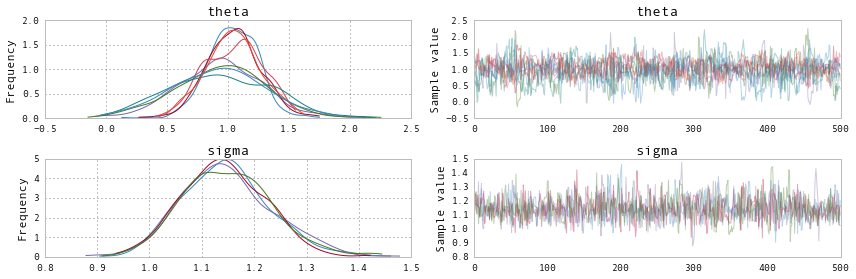

In [24]:
from pymc3 import traceplot

traceplot(trace, );

The left column consists of a kernel density estimation (KDE) of the marginal posterios of each RV while the right column contains the trace. As we ran four chains, each subplot will have 4 differently colored lines, one corresponding to each chain. Because `theta` is a 2-D RV we see two (times four) posteriors in the top row. This allows easy visual inspection of all chains converged to the same posterior.

A forest plot allows for a more succint overview of the posteriors as well as their Gelman-
Rubin $\hat{R}$ score (CITE):

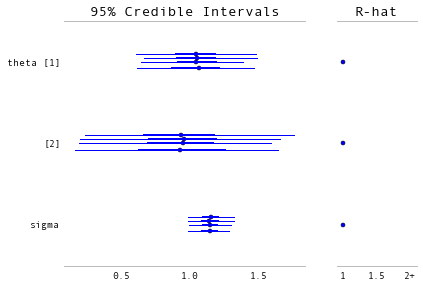

In [25]:
from pymc3 import forestplot

forestplot(trace)

In addition, `pm.stats.summary()` provides a text-based output of common posterior statistics:

In [29]:
from pymc3 import summary

summary(trace)


theta:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.045            0.219            0.010            [0.611, 1.458]
  0.935            0.380            0.017            [0.193, 1.670]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.616          0.894          1.049          1.190          1.475
  0.195          0.678          0.939          1.192          1.672


sigma:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.147            0.084            0.002            [0.997, 1.323]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.995          1.090          1.144

Here the 2-D RV is split into its individual components.

As you can see, `PyMC3` handles multiple chains as well as multivariate statistics natively.

## Case study: Occupancy estimation

Ecologists often use survey data to make inferences regarding the abundance and distribution of plants and animals. Such survey data is often *zero-inflated*, whereby there are more zeros than you would expect if the data were distributed according to some common distribution. This is sometimes due to habitat heterogeneity, which causes areas of low quality to be unoccupied by a particular species. However, some sites may be unoccupied simply due to chance.

Here is an example of such data; each element in the array (n=100) represents a count of a particular species among a set of sites. The data are clearly zero-inflated:

(array([ 67.,  11.,  15.,   3.,   3.,   1.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

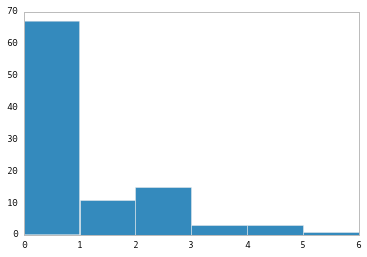

In [76]:
y = np.array([0, 2, 1, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 1,
       2, 0, 0, 0, 1, 0, 0, 0, 4, 2, 0, 0, 0, 1, 0, 2, 4, 0, 0, 1, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0,
       0, 0, 3, 0, 2, 0, 1, 2, 2, 2, 2, 3, 0, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0,
       0, 0, 2, 0, 0, 1, 0, 0])

pl.hist(y, bins=range(7))

We can use a *mixture model* to represent this data. The mixture is of two processes: an occupancy process, which determines whether a patch is suitable or not, and an abundance process that models the counts of organisms, conditional on occupancy. One way to tackle the problem is to model the latent state of 'occupancy' as a Bernoulli variable at each site, with some unknown probability. Then, the counts can be modeled using a discrete probability mass function, such as the Poisson, where its expected value represents the expected number of organisms sighted over a standard survey interval.

PyMC3 includes a zero-inflated Poisson distribution among its standard distributions, which takes a conditional mean parameter as well as an array of indicators for the excess zeros. Since we do not know which zeros are excess a priori, this array is an unknown stochastic node in the model, distributed as a Bernoulli random variable, with a hyperparameter representing the occupancy rate.

In [59]:
from pymc3 import Beta, Bernoulli, ZeroInflatedPoisson, Uniform

with Model() as zip_model:
    
    # Estimated occupancy
    p = Beta('p', 1, 1)

    # Latent variable for occupancy
    z = Bernoulli('z', p, y.shape)

    # Estimated mean count
    theta = Uniform('theta', 0, 100)

    # Poisson likelihood
    yd = ZeroInflatedPoisson('y', theta, z, observed=y)

Notice that this model includes discrete random variables, the latent occupancy indicators. Hence, we cannot use a gradient-based MCMC step method like HMC or NUTS. Instead, we will sample using a `BinaryMetropolis` sampler that proposes only binary values at each iteration; for the continuous-valued parameters, we will use a standard `Metropolis` sampler. 

In [60]:
from pymc3 import Metropolis, BinaryMetropolis

with zip_model:
    
    start = {'p': 0.5, 'z': (y > 0).astype(int), 'theta': 5}

    step1 = Metropolis([theta, p])

    step2 = BinaryMetropolis([z])

    trace = sample(10000, [step1, step2], start)

 [-----------------100%-----------------] 10000 of 10000 complete in 6.2 sec

The resulting posteriors for the unknown parameters suggest an occupancy rate in the neighborhood of 0.3 to 0.35, and an expected count (conditional on occupancy) of just over 2.

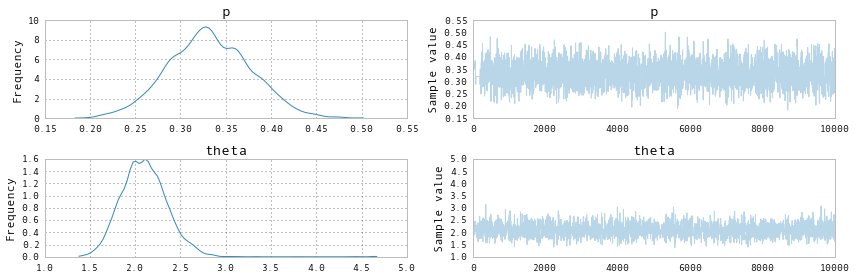

In [68]:
traceplot(trace, ['p', 'theta']);

## Backends

`PyMC3` has support for a small but growing number of backends to store traces in. These can be found in `pymc.backends`:

In [22]:
print_public(pm.backends)

['NDArray', 'SQLite', 'Text', 'base', 'ndarray', 'sqlite', 'text']


By default, an in-memory `ndarray` is used but if the samples would get too large to be held in memory we could use the `sqlite` backend:

In [23]:
with model_matrix:
    backend = pm.backends.SQLite('trace.sqlite')
    trace = pm.sample(500, step, start=start, trace=backend)

 [-----------------100%-----------------] 500 of 500 complete in 1.0 sec

The stored trace can then later be loaded using the `load` command:

In [24]:
with model_matrix:
    trace_loaded = pm.backends.sqlite.load('trace.sqlite')
    
trace_loaded 

<MultiTrace: 1 chains, 500 iterations, 3 variables>

More information about `backends` can be found in the docstring of `pymc.backends`.

## Defining arbitrary stochastic distributions

`PyMC3` supports two methods to define new distributions:

###1. Defining a distribution as a theano expression

By using `pymc.DensityDist` you can define new log probability functions that can be used like any other RV. The following is an example inspired by a blog post by Jake Vanderplas on which priors to use for a linear regression. (https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/). For more detail on the derivation of these priors we refer to the blog post. The code to use these custom priors is as follows:

In [25]:
import theano.tensor as T

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)
    # Create custom densities
    beta = pm.DensityDist('slope', lambda value: -1.5 * T.log(1 + value**2), testval=0)
    eps = pm.DensityDist('sigma', lambda value: -T.log(T.abs_(value)), testval=1)
    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X, sd=eps, observed=Y)

As you can see, `DensityDist` takes a function (here we are using an anonymous `lambda` function) that takes the parameter value as input and returns the log probability for that setting.

### 2. Defining a distribution as a blackbox function

Above we used `theano` to define the math of the probability function. However, often it might not be possible to write a probability distributions as a `theano` expression. This is the case in many scientific fields including psychology and astrophysics where the likelihood functions are often a model of the process in question and has a complex form that might require numerical approximation. As the rest of `PyMC3` still expects a `theano` expression we have to wrap a function as a blackbox `theano` expression. This is possible with the `as_op` decorator. As a simple example we can reformulate the above distribution for `beta` to only use `numpy` internally. 

In [26]:
import theano

@theano.compile.ops.as_op(itypes=[T.dscalar], otypes=[T.dscalar])
def beta_prior(value):
    return -1.5 * np.log(1 + value**2)

As can be seen, the decorator requires definition of the input and output types. For an overview of the available types, see http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors.

**Note**: Because this function is now a blackbox function it is not possible for `theano` to inspect it and compute the gradient required for the Hamiltonian samplers. It is thus not possible to use the `HMC` or `NUTS` samplers for a model that uses such a distribution and you have to use e.g. `Metropolis` or `Slice` sampling.

For a more elaborate example of the usage of `as_op` we refer to the coal mining disaster model: https://github.com/pymc-devs/pymc/blob/master/pymc/examples/disaster_model_arbitrary_deterministic.py.

## Parameter Transformations

To ease the sampling process it is often advisable to transform certain variables. For example, scale parameters can only be positive and thus have a sharp edge at 0 in their posterior probability. This often creates problems for samples, especially those that require the gradient because of non-differentiable areas in the posterior. Parameter transformation can remedy this problem. For example, log-transforming a scale variable allows us to sample across the whole parameter space. `PyMC3` supports transformations by calling the `model.TransformedVar` method:

In [33]:
with pm.Model() as model_linear:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1)
    
    sigma, log_sigma = model.TransformedVar('sigma', 
                                            pm.HalfNormal.dist(sd=1, testval=.1),
                                            pm.logtransform)
    
    Y_obs = pm.Normal('Y_obs', mu=alpha + beta * X, sd=sigma, observed=Y)

Of special note is that `TransformedVar` returns two distributions: one variable in the transformed space and one in the original space. The one in the transformed space (here `log(sigma)`) is the one over which sampling will occur in an unconstrained manner, and the one in the original space is the one to use throughout the rest of the model.

## Deterministic transformations

Above you have already seen that RVs in `PyMC3` can be easily combined and transformed (see the logistic regression example above). These transformations are called *deterministic*. However, note that in the above example we do not retain the samples of our transformed values (i.e. the `d`).  Using the `Deterministic` class we can explicitly add these deterministic variables to the trace.

# Generalized Linear Models

Generalized Linear Models (GLMs) are a class of widely used and flexible models to estimate relationships between a single outcome variable and one or multiple predictors. Above we have built Bayesian versions of linear as well as logistic regression. Because these models are so common, `PyMC3` offers a `glm` submodule that allows flexible creation of various GLMs with an intuitive `R`-like syntax that is implemented via the `patsy` module.

As the `glm` submodule requires data to be a `pandas` `DataFrame` we first have to convert `X` and `Y`:

In [ ]:
# Convert X and Y to a pandas DataFrame
import pandas as pd
df = pd.DataFrame({'x': X, 'y': Y})

The above linear regression can then equivalently be written with the `glm` module as follows:

In [35]:
with pm.Model() as model_glm:
    pm.glm.glm('y ~ x', df)

The `glm` doc string provides an overview of the capabilities.

In [2]:
help(pm.glm.glm)

Help on function glm in module pymc3.glm.glm:

glm(*args, **kwargs)
    Create GLM after Patsy model specification string.
    
    Parameters
    ----------
    formula : str
        Patsy linear model descriptor.
    data : array
        Labeled array (e.g. pandas DataFrame, recarray).
    priors : dict
        Mapping prior name to prior distribution.
        E.g. {'Intercept': Normal.dist(mu=0, sd=1)}
    intercept_prior : pymc3 distribution
        Prior to use for the intercept.
        Default: Normal.dist(mu=0, tau=1.0E-12)
    regressor_prior : pymc3 distribution
        Prior to use for all regressor(s).
        Default: Normal.dist(mu=0, tau=1.0E-12)
    init_vals : dict
        Set starting values externally: parameter -> value
        Default: None
    family : Family object
        Distribution of likelihood, see pymc3.glm.families
        (init has to be True).
    
    Output
    ------
    vars : List of created random variables (y_est, coefficients etc)
    
    Examp

We can thus also specify a logistic regression by passing in a `Binomial` family object.

In [ ]:
df_logistic = pd.DataFrame({'x': X, 'y': Y_logistic})

with pm.Model() as model_glm_logistic:
    pm.glm.glm('y ~ x', 
               df_logistic,
               family=pm.glm.families.Binomial()
    )

## Conclusions

PyMC3 offers state-of-the-art sampling algorithms including Hamiltonian Monte Carlo. PyMC3 is also fast due to just-in-time compilation of the model to C, mathematical simplifications of the and caching of previously computed values we gain speed by just-in-time compilation of the model log-likelihood and it's gradient to C,  automatic gradient calculation

## References

Patil, A., D. Huard and C.J. Fonnesbeck. (2010) PyMC: Bayesian Stochastic Modelling in Python. Journal of Statistical Software, 35(4), pp. 1-81

Bastien, F., Lamblin, P., Pascanu, R., Bergstra, J., Goodfellow, I., Bergeron, A., Bouchard, N., Warde-Farley, D., and Bengio, Y. (2012) “Theano: new features and speed improvements”. NIPS 2012 deep learning workshop.

Bergstra, J., Breuleux, O., Bastien, F., Lamblin, P., Pascanu, R., Desjardins, G., Turian, J., Warde-Farley, D., and Bengio, Y. (2010) “Theano: A CPU and GPU Math Expression Compiler”. Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX

Lunn, D.J., Thomas, A., Best, N., and Spiegelhalter, D. (2000) WinBUGS -- a Bayesian modelling framework: concepts, structure, and extensibility. Statistics and Computing, 10:325--337.

Neal, R.M. Slice sampling. Annals of Statistics. (2003). doi:10.2307/3448413.

van Rossum, G. The Python Library Reference Release 2.6.5., (2010). URL http://docs. python.org/library/.

Duane, S., Kennedy, A. D., Pendleton, B. J., and Roweth, D. (1987) “Hybrid Monte Carlo”, Physics Letters, vol. 195, pp. 216-222.

Stan Development Team. (2014). Stan: A C++ Library for Probability and Sampling, Version 2.5.0.   http://mc-stan.org. 

Gamerman, D. Markov Chain Monte Carlo: statistical simulation for Bayesian inference. Chapman and Hall, 1997.

Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research, 30.